# Anomalous detection system
* Used zeek to store around 2 weeks work of network data
* Data held around 600,000 packets from conn.log
* Cleaned the data
* One hot encoded non numerical data
* Constant kernal failures, had to reduce features ~55
* Simple tensorflow autoencoder
* 5 epochs
* PCA to visualize data

## Import Data
* Defined column names
* Loaded data into zeek_data

In [13]:
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import pandas as pd
import ipaddress
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import numpy as np
import joblib
from sklearn.ensemble import IsolationForest

pd.set_option('future.no_silent_downcasting', True)
column_names = ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'ip_proto']
zeek_data = pd.read_csv('./data.tsv', delimiter='\t', comment='#', names=column_names)
zeek_data


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,1.740197e+09,Covuo43LyFTNEu1Cp7,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.176656,0,...,T,F,0,^dAtt,34,1876,169,237196,-,6
1,1.740197e+09,CGgOtJ35xc6GxibRug,10.0.0.5,65289,140.82.112.26,443,tcp,-,0.089289,24,...,T,F,0,^dADFaRfR,6,300,5,325,-,6
2,1.740197e+09,CX6Ki51nhyiL2A6494,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.213978,1544,...,T,F,0,^dAttDa,29,3088,120,161605,-,6
3,1.740197e+09,CTSvKvuTLQBocHrOj,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,52768,2001:558:feed::1,53,udp,dns,0.019330,33,...,F,F,0,Dd,1,81,1,131,-,17
4,1.740197e+09,CtmXoQ1bMnUBBi68Pa,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,55558,2001:558:feed::1,53,udp,dns,0.017523,33,...,F,F,0,Dd,1,81,1,109,-,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589525,1.741251e+09,Cl9V7o3d5gUzwxmAmg,2601:647:cf01:5340:fa79:aff:fed6:65fb,1,2601:647:cf01:5340:210d:b639:9608:b036,0,icmp,-,156.840116,8290,...,F,F,0,-,97,12946,0,0,-,58
589526,1.741251e+09,CHc7xm1HIc1M2STFq7,fe80::833:d877:dbce:6f45,135,fe80::fa79:aff:fed6:65fb,136,icmp,-,838.535921,840,...,T,T,0,-,35,2520,35,2240,-,58
589527,1.741251e+09,C9j7yS2Mqpn8AqAIVc,fe80::833:d877:dbce:6f45,136,fe80::fa79:aff:fed6:65fb,135,icmp,-,871.438452,576,...,T,T,0,-,36,2304,16,1152,-,58
589528,1.741251e+09,ChOLqy4F73Wl6qIVsj,73.92.54.210,3,10.0.0.5,1,icmp,-,892.440025,122608,...,F,T,0,-,1703,170292,0,0,-,1


## Data Cleaning
* Dropped rows with missing values
*

In [14]:
# Drop rows with missing values
zeek_data = zeek_data.dropna()

zeek_data = zeek_data.dropna(axis=1, how='all')  # Drop columns with all NaN values
zeek_data['ts'] = pd.to_datetime(zeek_data['ts'], unit='s')
zeek_data

zeek_data.columns = zeek_data.columns.str.strip()  # Remove any leading/trailing spaces
zeek_data.columns = zeek_data.columns.str.lower()  # Convert all column names to lowercase
zeek_data

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,2025-02-22 03:55:46.358164072,Covuo43LyFTNEu1Cp7,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.176656,0,...,T,F,0,^dAtt,34,1876,169,237196,-,6
1,2025-02-22 03:55:46.358163118,CGgOtJ35xc6GxibRug,10.0.0.5,65289,140.82.112.26,443,tcp,-,0.089289,24,...,T,F,0,^dADFaRfR,6,300,5,325,-,6
2,2025-02-22 03:56:08.851763010,CX6Ki51nhyiL2A6494,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.213978,1544,...,T,F,0,^dAttDa,29,3088,120,161605,-,6
3,2025-02-22 03:57:40.816343069,CTSvKvuTLQBocHrOj,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,52768,2001:558:feed::1,53,udp,dns,0.019330,33,...,F,F,0,Dd,1,81,1,131,-,17
4,2025-02-22 03:57:40.816483021,CtmXoQ1bMnUBBi68Pa,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,55558,2001:558:feed::1,53,udp,dns,0.017523,33,...,F,F,0,Dd,1,81,1,109,-,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589525,2025-03-06 08:57:15.893676996,Cl9V7o3d5gUzwxmAmg,2601:647:cf01:5340:fa79:aff:fed6:65fb,1,2601:647:cf01:5340:210d:b639:9608:b036,0,icmp,-,156.840116,8290,...,F,F,0,-,97,12946,0,0,-,58
589526,2025-03-06 08:45:46.176140070,CHc7xm1HIc1M2STFq7,fe80::833:d877:dbce:6f45,135,fe80::fa79:aff:fed6:65fb,136,icmp,-,838.535921,840,...,T,T,0,-,35,2520,35,2240,-,58
589527,2025-03-06 08:45:26.384061098,C9j7yS2Mqpn8AqAIVc,fe80::833:d877:dbce:6f45,136,fe80::fa79:aff:fed6:65fb,135,icmp,-,871.438452,576,...,T,T,0,-,36,2304,16,1152,-,58
589528,2025-03-06 08:45:18.768332958,ChOLqy4F73Wl6qIVsj,73.92.54.210,3,10.0.0.5,1,icmp,-,892.440025,122608,...,F,T,0,-,1703,170292,0,0,-,1


In [15]:
zeek_data.isnull().sum()



,0
ts,0
uid,0
id.orig_h,0
id.orig_p,0
id.resp_h,0
id.resp_p,0
proto,0
service,0
duration,0
orig_bytes,0


In [16]:
zeek_data.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'ip_proto'],
      dtype='object')

In [17]:
zeek_data['duration'].fillna(0, inplace=True)
zeek_data['orig_bytes'].fillna(0, inplace=True)
zeek_data['resp_bytes'].fillna(0, inplace=True)
zeek_data.head()

<ipython-input-17-9a78cb1acfe6>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  zeek_data['duration'].fillna(0, inplace=True)
<ipython-input-17-9a78cb1acfe6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,2025-02-22 03:55:46.358164072,Covuo43LyFTNEu1Cp7,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.176656,0,...,T,F,0,^dAtt,34,1876,169,237196,-,6
1,2025-02-22 03:55:46.358163118,CGgOtJ35xc6GxibRug,10.0.0.5,65289,140.82.112.26,443,tcp,-,0.089289,24,...,T,F,0,^dADFaRfR,6,300,5,325,-,6
2,2025-02-22 03:56:08.851763010,CX6Ki51nhyiL2A6494,10.0.0.5,65430,99.181.107.78,443,tcp,-,0.213978,1544,...,T,F,0,^dAttDa,29,3088,120,161605,-,6
3,2025-02-22 03:57:40.816343069,CTSvKvuTLQBocHrOj,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,52768,2001:558:feed::1,53,udp,dns,0.019330,33,...,F,F,0,Dd,1,81,1,131,-,17
4,2025-02-22 03:57:40.816483021,CtmXoQ1bMnUBBi68Pa,2601:647:cf01:5340:6d8b:e871:9ba9:5a18,55558,2001:558:feed::1,53,udp,dns,0.017523,33,...,F,F,0,Dd,1,81,1,109,-,17


In [18]:
zeek_data['duration'] = pd.to_numeric(zeek_data['duration'], errors='coerce')  # Convert duration to numeric (coerce invalid values to NaN)
zeek_data['orig_bytes'] = pd.to_numeric(zeek_data['orig_bytes'], errors='coerce')  # Convert orig_bytes to numeric
zeek_data['resp_bytes'] = pd.to_numeric(zeek_data['resp_bytes'], errors='coerce')  # Convert resp_bytes to numeric
zeek_data = zeek_data.dropna()

In [19]:

features = zeek_data.drop(columns=['uid', 'ts', 'id.orig_h','id.resp_h', 'history' ])
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
Index: 530061 entries, 0 to 589529
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id.orig_p       530061 non-null  int64  
 1   id.resp_p       530061 non-null  int64  
 2   proto           530061 non-null  object 
 3   service         530061 non-null  object 
 4   duration        530061 non-null  float64
 5   orig_bytes      530061 non-null  float64
 6   resp_bytes      530061 non-null  float64
 7   conn_state      530061 non-null  object 
 8   local_orig      530061 non-null  object 
 9   local_resp      530061 non-null  object 
 10  missed_bytes    530061 non-null  int64  
 11  orig_pkts       530061 non-null  int64  
 12  orig_ip_bytes   530061 non-null  int64  
 13  resp_pkts       530061 non-null  int64  
 14  resp_ip_bytes   530061 non-null  int64  
 15  tunnel_parents  530061 non-null  object 
 16  ip_proto        530061 non-null  int64  
dtypes: float64(3), 

,id.orig_p,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,65430,443,tcp,-,0.176656,0.0,228408.0,OTH,T,F,0,34,1876,169,237196,-,6
1,65289,443,tcp,-,0.089289,24.0,65.0,SF,T,F,0,6,300,5,325,-,6
2,65430,443,tcp,-,0.213978,1544.0,156813.0,OTH,T,F,0,29,3088,120,161605,-,6
3,52768,53,udp,dns,0.019330,33.0,83.0,SF,F,F,0,1,81,1,131,-,17
4,55558,53,udp,dns,0.017523,33.0,61.0,SF,F,F,0,1,81,1,109,-,17


## Visualization of Data
- Use seaborn to see data matrix

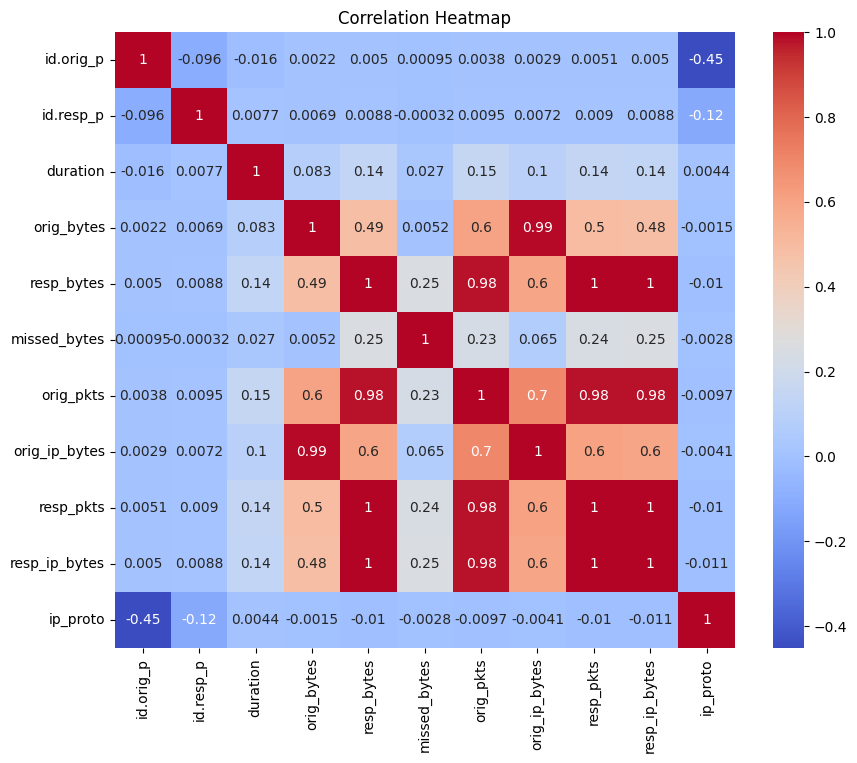

In [20]:
# Seaborn heatmap
data_plot = features.drop(columns=['proto', 'service', 'conn_state', 'local_orig', 'local_resp', 'tunnel_parents'])
plt.figure(figsize=(10, 8))
sns.heatmap(data_plot.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

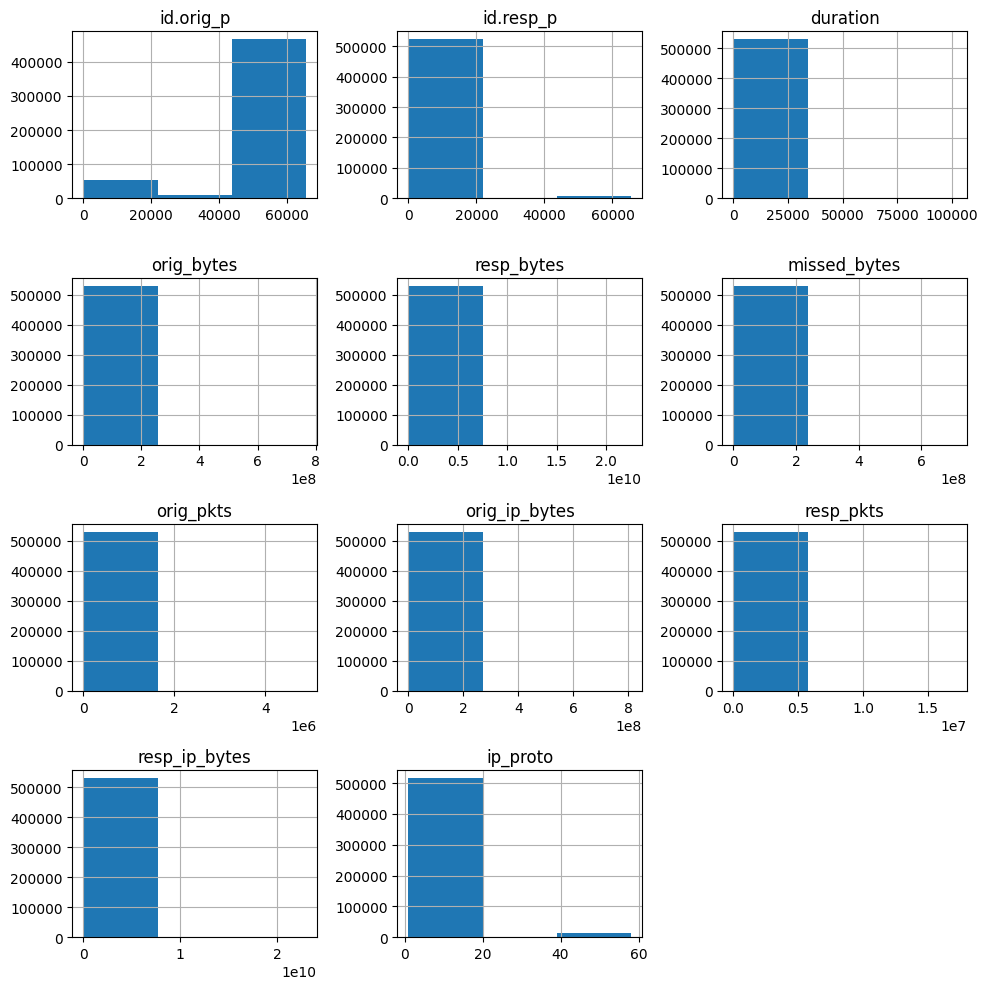

In [21]:
# Histograms Plots
features.hist(figsize=(10, 10), bins=3)
plt.tight_layout()
plt.show()

In [22]:
# Odd distribution
# Makese sense given how dynamic network data can be
features.describe()



,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,ip_proto
count,530061.000000,530061.000000,530061.000000,5.300610e+05,5.300610e+05,5.300610e+05,5.300610e+05,5.300610e+05,5.300610e+05,5.300610e+05,530061.000000
mean,51328.834902,1290.372908,29.096325,1.309615e+04,7.626067e+05,3.077618e+03,1.369800e+02,1.986617e+04,5.882601e+02,7.896991e+05,15.443126
std,16894.055305,6513.634842,477.128139,1.907559e+06,5.069602e+07,1.249100e+06,1.046979e+04,2.150193e+06,3.856581e+04,5.203388e+07,8.263247
min,0.000000,0.000000,0.000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
25%,51377.000000,53.000000,0.019716,3.600000e+01,7.700000e+01,0.000000e+00,1.000000e+00,8.100000e+01,1.000000e+00,1.220000e+02,17.000000
50%,55989.000000,53.000000,0.028393,4.900000e+01,1.230000e+02,0.000000e+00,1.000000e+00,9.600000e+01,1.000000e+00,1.710000e+02,17.000000
75%,60796.000000,443.000000,1.504369,1.452000e+03,2.175000e+03,0.000000e+00,1.200000e+01,2.507000e+03,1.000000e+01,2.826000e+03,17.000000
max,65535.000000,65388.000000,101771.212935,7.662673e+08,2.246276e+10,7.108595e+08,4.885329e+06,8.087133e+08,1.715875e+07,2.294321e+10,58.000000


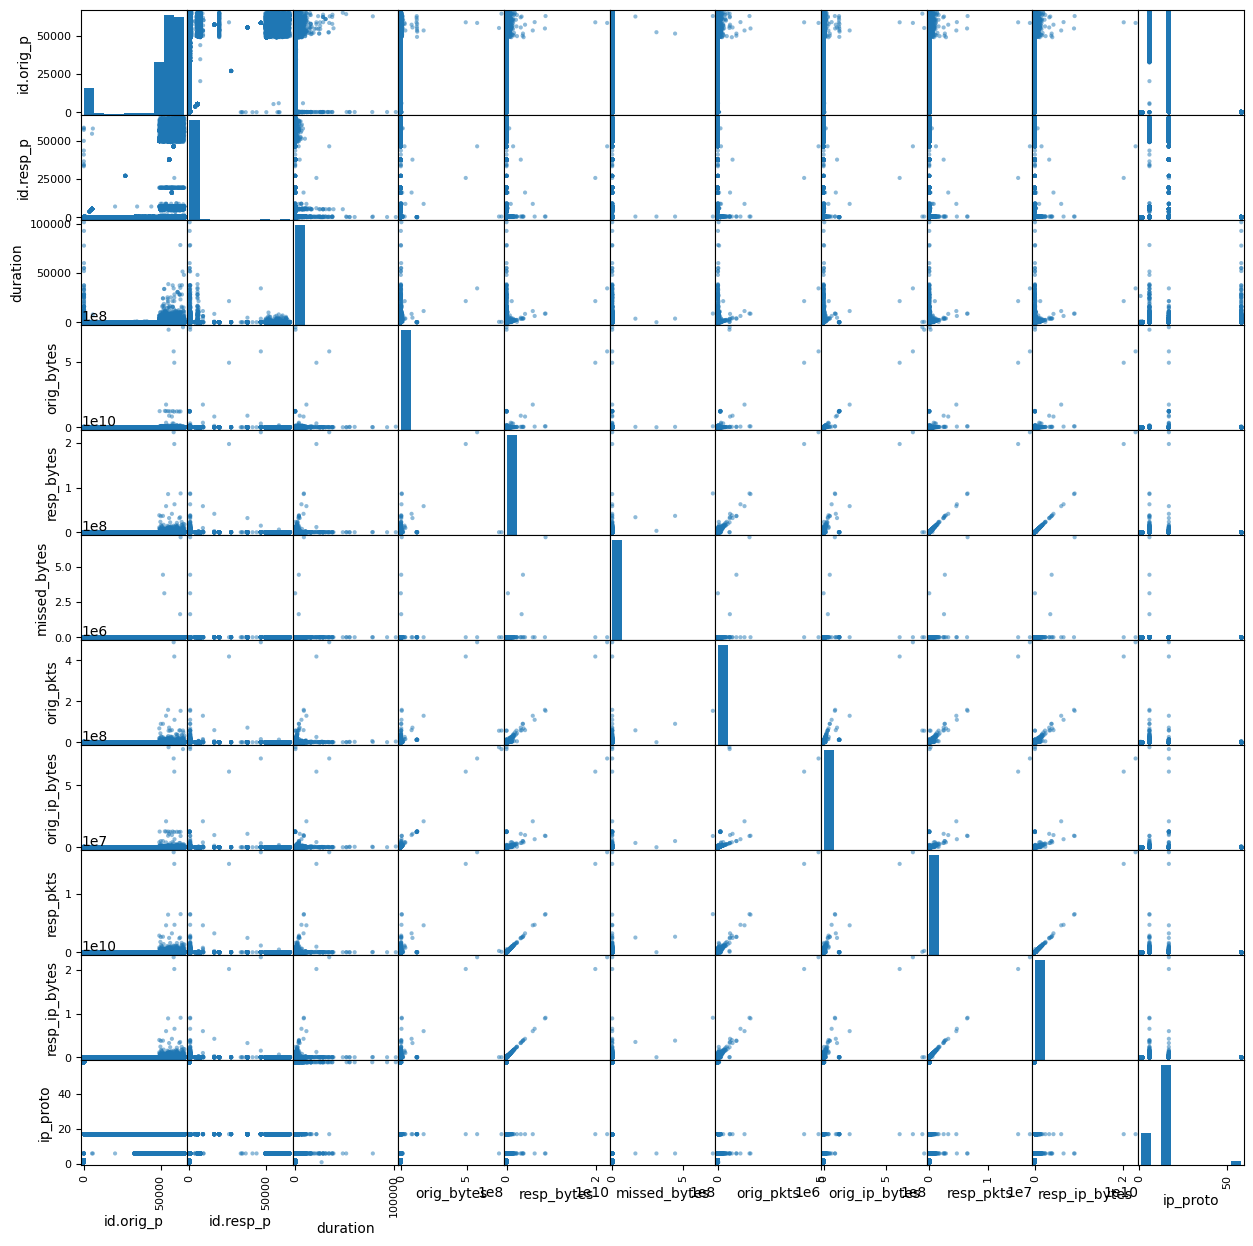

In [23]:
scatter_matrix(data_plot, figsize=(15, 15), diagonal='hist')
plt.show()

In [86]:

zeek_data_encoded = pd.get_dummies(features, columns=['proto', 'service', 'conn_state', 'local_orig', 'local_resp', 'tunnel_parents' ], drop_first=True, dtype=float)
zeek_data_encoded.info()
zeek_data_encoded

<class 'pandas.core.frame.DataFrame'>
Index: 530061 entries, 0 to 589529
Data columns (total 53 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id.orig_p                        530061 non-null  int64  
 1   id.resp_p                        530061 non-null  int64  
 2   duration                         530061 non-null  float64
 3   orig_bytes                       530061 non-null  float64
 4   resp_bytes                       530061 non-null  float64
 5   missed_bytes                     530061 non-null  int64  
 6   orig_pkts                        530061 non-null  int64  
 7   orig_ip_bytes                    530061 non-null  int64  
 8   resp_pkts                        530061 non-null  int64  
 9   resp_ip_bytes                    530061 non-null  int64  
 10  ip_proto                         530061 non-null  int64  
 11  proto_tcp                        530061 non-null  float64
 12  proto_u

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,...,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR,local_orig_T,local_resp_T
0,65430,443,0.176656,0.0,228408.0,0,34,1876,169,237196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,65289,443,0.089289,24.0,65.0,0,6,300,5,325,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,65430,443,0.213978,1544.0,156813.0,0,29,3088,120,161605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,52768,53,0.019330,33.0,83.0,0,1,81,1,131,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,55558,53,0.017523,33.0,61.0,0,1,81,1,109,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589525,1,0,156.840116,8290.0,0.0,0,97,12946,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589526,135,136,838.535921,840.0,560.0,0,35,2520,35,2240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
589527,136,135,871.438452,576.0,384.0,0,36,2304,16,1152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
589528,3,1,892.440025,122608.0,0.0,0,1703,170292,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Fit Model
- Scaled Data
- Split data
- Trained on an autoencoded nueral net
- Used a bottleneck archtecture
- Threshold is around 98

In [76]:


# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(zeek_data_encoded)

original_indices = zeek_data_encoded.index.tolist()
X_train, X_test, train_indices, test_indices = train_test_split( features_scaled, original_indices, test_size=0.2, random_state=42 )

# Build the Sequential Autoencoder Model
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if no improvement for 5 epochs
    restore_best_weights=True,
    min_delta=0.001  # Only count improvements > 0.001
)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'), # Bottle neck layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(X_train.shape[1], activation='linear')
])
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), callbacks=[early_stopping] )

reconstructions = model.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

threshold = np.percentile(mse, 98)

anomalies = mse > threshold
print(f"Anomalies detected: {np.sum(anomalies)}")

anomalous_test_indices = np.where(anomalies)[0]
anomalous_original_indices = [test_indices[i] for i in anomalous_test_indices]
anomalous_traffic = zeek_data_encoded.loc[anomalous_original_indices]
print(anomalous_traffic)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - loss: 0.7450 - val_loss: 0.4629
Epoch 2/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 88s 4ms/step - loss: 0.6731 - val_loss: 0.3829
Epoch 3/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - loss: 0.4803 - val_loss: 0.3311
Epoch 4/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step - loss: 0.5240 - val_loss: 0.3124
Epoch 5/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 0.5195 - val_loss: 0.2951
Epoch 6/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 0.4349 - val_loss: 0.2973
Epoch 7/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - loss: 0.4543 - val_loss: 0.2877
Epoch 8/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - loss: 0.4451 - val_loss: 0.2801
Epoch 9/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - loss: 0.3791 - val_loss: 0.2679
Epoch 10/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - loss: 0.3923 - val_loss: 0.3139
Epoch 11/50
13252/13252 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - loss: 0.4424 - val_loss: 0.3

In [77]:
# Mount drive (you already did this ✅)
from google.colab import drive
drive.mount('/content/drive')

# Save with new format
model.save('/content/drive/MyDrive/network_anomaly_model3.keras')

# Save other components (these stay the same)
import joblib
joblib.dump(scaler, '/content/drive/MyDrive/scaler.pkl')
joblib.dump(threshold, '/content/drive/MyDrive/threshold.pkl')

print("✅ Model saved in native Keras format!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved in native Keras format!
